In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
# Sample dates and stock names
dates = pd.date_range("2023-01-01", periods=50, freq="D")
stocks = ["AAPL", "GOOG", "MSFT"]

# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])
np.random.seed(42)  # For reproducibility

# Generate some sample data
data = {
    "price": np.random.normal(0, 1, len(index)),
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)
print(finance_df)

# Display the DataFrame
def sharpe_loss(params, X, y, dates, alpha=0.001):
    weights = params[:-1]
    intercept = params[-1]
    # Compute predictions using linear regression

    predictions = X @ weights + intercept
    return np.sum(np.square(predictions - y)) + alpha * np.sum(np.square(params)) 

    # Convert predictions into a Series with the same index as dates
    pred_series = pd.Series(predictions, index=dates)
    # Normalize predictions within each day to use as weights
    norm_pred = pred_series.groupby(level=0).transform(lambda x: x / x.abs().sum())
    # Compute weighted (actual) returns and aggregate them by day
    weighted_returns = norm_pred * y
    daily_returns = pd.Series(weighted_returns, index=dates).groupby(level=0).sum()
    # Calculate Sharpe ratio: mean over std of daily returns
    sharpe_ratio = daily_returns.mean() / daily_returns.std()
    # time.sleep(1000)
    print("Sharpe ratio:", sharpe_ratio)
    return -sharpe_ratio + alpha * np.sum(np.square(params))  # Negative Sharpe ratio with regularization term

# Prepare input data from finance_df
X = finance_df[['price', 'volume']].values
# print(X)
y = finance_df['return'].values
dates = finance_df.index.get_level_values('date')
# print(dates)


# Initialize parameters: one weight per feature plus an intercept
np.random.seed()  # For reproducibility
initial_params = np.random.normal(0, 1, X.shape[1] + 1)
# initial_params = [1, 0, 0]
bounds = [(0.9, 1.1), (0, 0.0), (0, 0)]

# Optimize the parameters to maximize the Sharpe ratio (minimize negative Sharpe ratio)
result = minimize(sharpe_loss, initial_params, args=(X, y, dates), method='L-BFGS-B', bounds=bounds)

# Extract the optimized weights and intercept
optimized_weights = result.x[:-1]
optimized_intercept = result.x[-1]

print("Optimized weights:", optimized_weights)
print("Optimized intercept:", optimized_intercept)


                     price    volume    return
date       stock                              
2023-01-01 AAPL   0.496714  0.193543  0.494206
           GOOG  -0.138264  0.139938 -0.140772
           MSFT   0.647689  0.071016  0.645181
2023-01-02 AAPL   1.523030 -0.207930  1.520522
           GOOG  -0.234153 -0.169186 -0.236661
...                    ...       ...       ...
2023-02-18 GOOG   0.781823 -0.033074  0.779315
           MSFT  -1.236951 -0.050748 -1.239458
2023-02-19 AAPL  -1.320457  0.057925 -1.322964
           GOOG   0.521942  0.067547  0.519434
           MSFT   0.296985 -0.227348  0.294477

[150 rows x 3 columns]
Optimized weights: [1.00022477 0.        ]
Optimized intercept: 0.0


In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.99, 0.0, 0.0, 0.0],
    [0.99, 1, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.99],
    [0.0, 0.0, 0.0, -0.99, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 1, -0.1, 0.5, -0.2]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index))
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)


# Filter the data for the given date range
filtered_data = finance_df.loc["2015-01-01":"2018-12-20", "price"].unstack(level="stock")

# Compute the correlation and covariance matrices for the filtered data
price_correlation_matrix = filtered_data.corr().loc[stocks, stocks]
price_cov_matrix = filtered_data.cov().loc[stocks, stocks]
print("Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:")
print(price_correlation_matrix)

# Replace cholesky decomposition with eigenvalue decomposition for the correlation matrix
eigenvalues_corr, eigenvectors_corr = np.linalg.eigh(price_correlation_matrix)
eigenvalues_corr[eigenvalues_corr < 0] = 0  # Ensure non-negative eigenvalues
sqrt_eigenvalues_corr = np.sqrt(eigenvalues_corr)
transform_matrix_corr = np.round(eigenvectors_corr @ np.diag(sqrt_eigenvalues_corr) @ eigenvectors_corr.T, 3)

# Eigenvalue decomposition for the covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(price_cov_matrix)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T

print("Eigen transform matrix for the price correlation matrix:\n", transform_matrix_corr)

# Transform the returns using the new eigen-based matrices
returns_matrix = finance_df['return'].unstack(level='stock')[stocks].values
transposed_returns = returns_matrix @ transform_matrix_corr.T
transposed_returns_cov = returns_matrix @ transform_matrix_cov.T

# Flatten the transposed returns and add them as new columns in finance_df
finance_df['transposed_return'] = transposed_returns.flatten(order='C')
finance_df['transposed_return_cov'] = transposed_returns_cov.flatten(order='C')
finance_df.head(20)


Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:
stock      GOOG      AAPL      MSFT      AMZN      TSLA
stock                                                  
GOOG   1.000000  0.989373  0.017456  0.002237 -0.004044
AAPL   0.989373  1.000000  0.013245 -0.000002 -0.001935
MSFT   0.017456  0.013245  1.000000  0.002337 -0.003193
AMZN   0.002237 -0.000002  0.002337  1.000000 -0.990204
TSLA  -0.004044 -0.001935 -0.003193 -0.990204  1.000000
Eigen transform matrix for the price correlation matrix:
 [[ 0.757  0.654  0.008  0.001 -0.002]
 [ 0.654  0.757  0.004 -0.001 -0.001]
 [ 0.008  0.004  1.     0.001 -0.002]
 [ 0.001 -0.001  0.001  0.755 -0.656]
 [-0.002 -0.001 -0.002 -0.656  0.755]]


price    volume    return  transposed_return  \
date       stock                                                    
2015-01-01 GOOG   0.496714 -0.089372 -0.479459          -1.032462   
           AAPL   0.613310 -0.198490 -1.028068          -1.087831   
           MSFT   0.547689 -0.214096  0.502002           0.492883   
           AMZN   2.023030 -0.202862 -1.706863          -1.111928   
           TSLA  -2.064044  0.041435 -0.267839           0.918466   
2015-01-02 GOOG  -0.234137 -0.224169 -2.553631          -2.814402   
           AAPL   0.132047 -0.081537 -1.336402          -2.687025   
           MSFT   0.667435  0.126600 -0.877134          -0.903188   
           AMZN   0.030526 -0.102826  1.096724           0.374534   
           TSLA   0.018104  0.131654  0.688108          -0.191732   
2015-01-03 GOOG  -0.463418  0.122734 -0.553935           0.067388   
           AAPL  -0.383415 -0.127086  0.729370           0.194955   
           MSFT   0.141962  0.114411  0.887623           0.888717   
           AMZN  -1.413280  0.123888 -0.160665           0.786454   
           TSLA   1.127604 -0.051273 -1.384378          -0.941206   
2015-01-04 GOOG  -0.562288 -0.144790 -0.207912          -0.231463   
           AAPL  -0.558475  0.010635 -0.097892          -0.215656   
           MSFT   0.214247  0.210699 -1.232454          -1.234702   
           AMZN  -0.408024  0.069808  0.367047           0.092221   
           TSLA   0.176500 -0.163539  0.279812          -0.026546   

                  transposed_return_cov  
date       stock                         
2015-01-01 GOOG               -1.036998  
           AAPL               -1.088825  
           MSFT                0.497177  
           AMZN               -1.099977  
           TSLA                0.909943  
2015-01-02 GOOG               -2.830931  
           AAPL               -2.692138  
           MSFT               -0.912807  
           AMZN                0.369550  
           TSLA               -0.189967  
2015-01-03 GOOG                0.066161  
           AAPL                0.193720  
           MSFT                0.896530  
           AMZN                0.779694  
           TSLA               -0.934332  
2015-01-04 GOOG               -0.233161  
           AAPL               -0.216523  
           MSFT               -1.246254  
           AMZN                0.091137  
           TSLA               -0.026518

In [3]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.5, 0.0, 0.0, 0.0],
    [0.5, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.8],
    [0.0, 0.0, 0.0, -0.8, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 1, -0.1, 0.5, -0.2]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index))
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)

# Sort the data by date and stock
finance_df.sort_index(inplace=True)
stocks = sorted(stocks)
print(stocks)
# Filter the data for the given date range
filtered_data = finance_df.loc["2015-01-01":"2018-12-20", "price"].unstack(level="stock")

# Compute the correlation matrix for the filtered data
price_correlation_matrix = filtered_data.corr().loc[stocks, stocks]
price_cov_matrix = filtered_data.cov().loc[stocks, stocks]
print("Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:")
print(price_correlation_matrix)

# Replace cholesky decomposition with eigenvalue decomposition for correlation matrix
eigenvalues_corr, eigenvectors_corr = np.linalg.eigh(price_correlation_matrix)
eigenvalues_corr[eigenvalues_corr < 0] = 0  # Ensure non-negative eigenvalues
sqrt_eigenvalues_corr = np.sqrt(eigenvalues_corr)
transform_matrix_corr = np.round(eigenvectors_corr @ np.diag(sqrt_eigenvalues_corr) @ eigenvectors_corr.T, 3)

# Eigenvalue decomposition for covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(price_cov_matrix)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T

print("Eigen transform matrix for the price correlation matrix:\n", transform_matrix_corr)

# Transform the returns using the new eigen-based matrices
returns_matrix = finance_df['return'].unstack(level='stock').values
transposed_returns = returns_matrix @ transform_matrix_corr.T
transposed_returns_cov = returns_matrix @ transform_matrix_cov.T

# Flatten the transposed returns and add it as a new column in finance_df
finance_df['transposed_return'] = transposed_returns.flatten(order='C')
finance_df['transposed_return_cov'] = transposed_returns_cov.flatten(order='C')
finance_df.head(20)


['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
Correlation matrix for the price of stocks between 2015-01-01 and 2015-01-20:
stock      AAPL      AMZN      GOOG      MSFT      TSLA
stock                                                  
AAPL   1.000000 -0.012413  0.468123 -0.016292  0.003099
AMZN  -0.012413  1.000000  0.002237  0.002337 -0.805862
GOOG   0.468123  0.002237  1.000000  0.017456 -0.009558
MSFT  -0.016292  0.002337  0.017456  1.000000 -0.005611
TSLA   0.003099 -0.805862 -0.009558 -0.005611  1.000000
Eigen transform matrix for the price correlation matrix:
 [[ 0.97  -0.007  0.241 -0.009  0.001]
 [-0.007  0.892  0.001  0.001 -0.452]
 [ 0.241  0.001  0.97   0.01  -0.005]
 [-0.009  0.001  0.01   1.    -0.003]
 [ 0.001 -0.452 -0.005 -0.003  0.892]]


price    volume    return  transposed_return  \
date       stock                                                    
2015-01-01 AAPL   0.994642 -0.198490 -1.028068          -1.105613   
           AMZN   2.023030 -0.202862 -1.706863          -1.394239   
           GOOG   0.496714 -0.089372 -0.479459          -0.708188   
           MSFT   0.547689 -0.214096  0.502002           0.505557   
           TSLA  -1.878916  0.041435 -0.267839           0.532452   
2015-01-02 AAPL   2.116595 -0.081537 -1.336402          -1.910830   
           AMZN   0.030526 -0.102826  1.096724           0.673177   
           GOOG  -0.234137 -0.224169 -2.553631          -2.810210   
           MSFT   0.667435  0.126600 -0.877134          -0.891610   
           TSLA   0.181116  0.131654  0.688108           0.132136   
2015-01-03 AAPL   0.230983 -0.127086  0.729370           0.565742   
           AMZN  -1.413280  0.123888 -0.160665           0.477654   
           GOOG  -0.463418  0.122734 -0.553935          -0.345901   
           MSFT   0.141962  0.114411  0.887623           0.879512   
           TSLA  -0.024327 -0.051273 -1.384378          -1.161409   
2015-01-04 AAPL  -0.292256  0.010635 -0.097892          -0.136260   
           AMZN  -0.408024  0.069808  0.367047           0.200176   
           GOOG  -0.562288 -0.144790 -0.207912          -0.238624   
           MSFT   0.214247  0.210699 -1.232454          -1.234125   
           TSLA  -0.640963 -0.163539  0.279812           0.088326   

                  transposed_return_cov  
date       stock                         
2015-01-01 AAPL               -1.119960  
           AMZN               -1.380263  
           GOOG               -0.713122  
           MSFT                0.511516  
           TSLA                0.527527  
2015-01-02 AAPL               -1.932131  
           AMZN                0.665961  
           GOOG               -2.828534  
           MSFT               -0.899580  
           TSLA                0.134055  
2015-01-03 AAPL                0.572965  
           AMZN                0.474042  
           GOOG               -0.347289  
           MSFT                0.887071  
           TSLA               -1.157423  
2015-01-04 AAPL               -0.137134  
           AMZN                0.198425  
           GOOG               -0.240242  
           MSFT               -1.245621  
           TSLA                0.088529

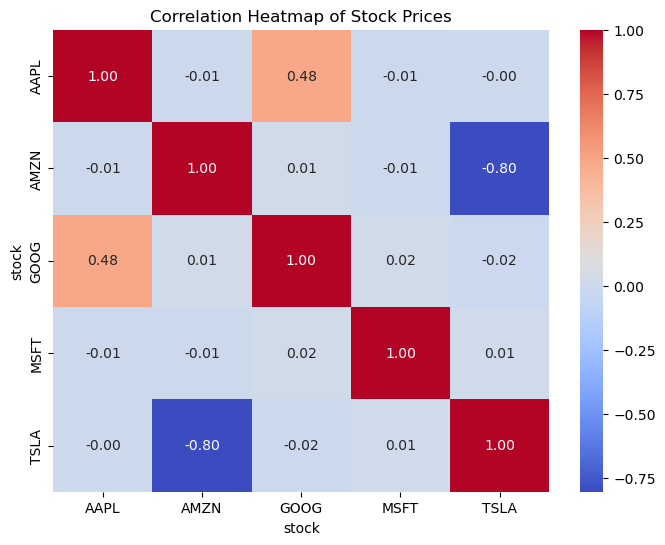

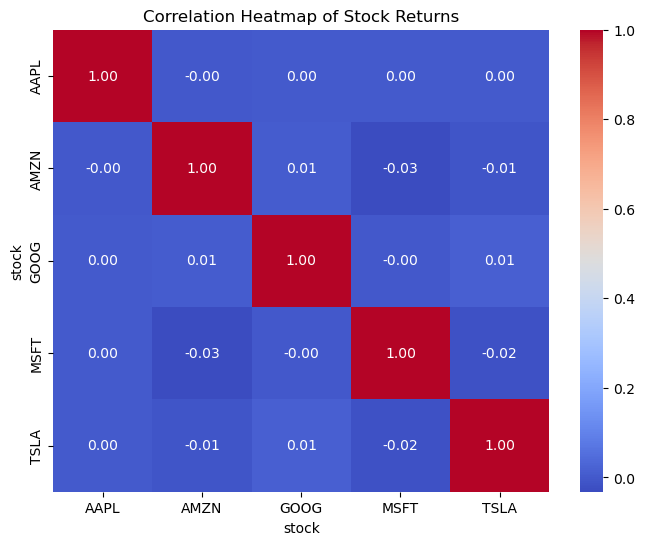

In [4]:
import seaborn as sns



import matplotlib.pyplot as plt

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['price'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Prices")
plt.show()

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['return'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Returns")
plt.show()

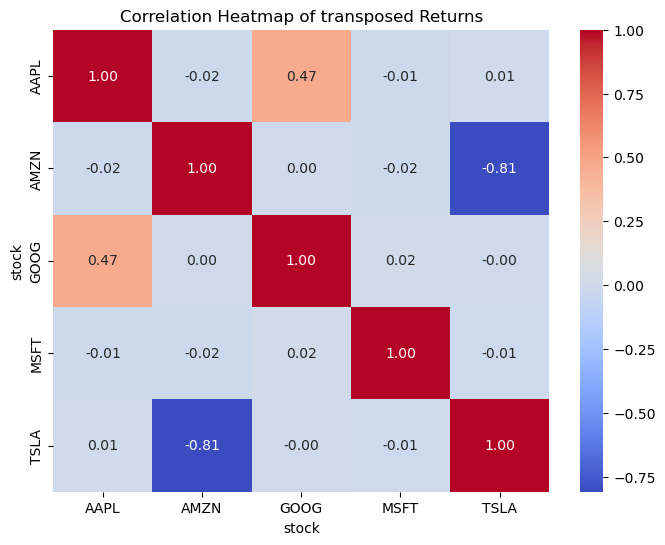

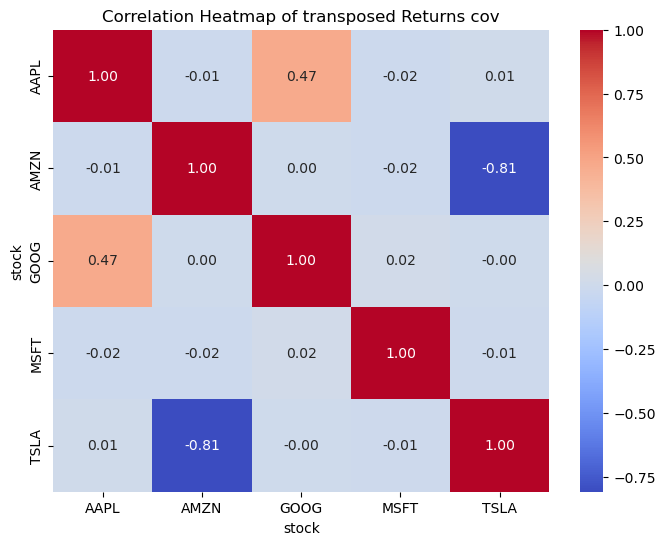

In [5]:

# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['transposed_return'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of transposed Returns")
plt.show()


# Pivot the finance_df to create a matrix of prices for each stock over time
price_matrix = finance_df['transposed_return_cov'].unstack(level='stock')

# Compute the correlation matrix
correlation_matrix = price_matrix.corr()
# Reorder the correlation matrix to match the order in the dataframe
correlation_matrix = correlation_matrix.loc[stocks, stocks]
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of transposed Returns cov")
plt.show()

In [6]:
import numpy as np
import pandas as pd

# Example correlation matrix
C = np.array([
    [1.0, 0.9],
    [0.9, 1.0]
])

# Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(C)
# Ensure non-negative eigenvalues for sqrt (adjust if needed)
eigenvalues[eigenvalues < 0] = 0
sqrt_eigenvalues = np.sqrt(eigenvalues)
# Construct the transformation matrix
transform_matrix = eigenvectors @ np.diag(sqrt_eigenvalues) @ eigenvectors.T
print("Transform matrix:")
print(transform_matrix)
# Generate uncorrelated random variables
n_samples = 100
uncorrelated = np.random.normal(size=(n_samples, C.shape[0]))

# Generate correlated random variables
correlated = uncorrelated @ transform_matrix.T
print(correlated)
# Convert the correlated array to a pandas DataFrame
correlated_df = pd.DataFrame(correlated, columns=["Var1", "Var2"])

# Compute and print the correlation matrix
print(correlated_df.corr())

Transform matrix:
[[0.84731632 0.53108855]
 [0.53108855 0.84731632]]
[[ 7.63321725e-02 -1.56325209e-01]
 [ 4.90222000e-01 -7.21620487e-02]
 [-6.68564794e-01 -1.16191802e-03]
 [-5.12248602e-01 -4.83901550e-01]
 [-7.82324940e-01 -7.33586892e-01]
 [ 2.07174719e+00  2.15379733e+00]
 [ 2.09986528e+00  1.87696960e+00]
 [-3.65591237e-01 -9.65967628e-01]
 [ 9.86534883e-01  1.72786105e+00]
 [ 4.35035527e-01  1.05160569e+00]
 [-1.37569802e+00 -2.24000486e+00]
 [ 1.21518725e+00  1.41307282e+00]
 [ 6.13344192e-01  1.01876304e+00]
 [-2.14903480e+00 -2.05977532e+00]
 [ 4.26975043e-01  5.13068185e-01]
 [ 1.48877689e+00  1.26183464e+00]
 [-8.98235317e-01 -4.53405715e-01]
 [-4.86378057e-01 -1.26902959e+00]
 [-2.15195399e-01 -3.07517803e-01]
 [-2.89837343e-01  7.49219381e-02]
 [-7.52743983e-01 -2.57353886e-01]
 [ 1.04964025e+00  1.21542968e+00]
 [-1.75130414e+00 -1.87204463e+00]
 [ 8.42842026e-02 -9.44397749e-02]
 [ 2.70296623e+00  1.93005757e+00]
 [-4.25055816e-02 -1.15550928e-01]
 [-7.32612642e-01 -1.

In [7]:
# Example of time-aware cross validation using TimeSeriesSplit
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a sample time series dataset
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
data = pd.DataFrame({
    'feature': np.random.randn(100),
    'target': np.random.randn(100)
}, index=dates)
print(data)
X = data[['feature']].values
y = data['target'].values

# Set up a time series split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model on past data and test on future data
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    print("Train period:", data.index[train_index[0]], "to", data.index[train_index[-1]])
    print("Test period:", data.index[test_index[0]], "to", data.index[test_index[-1]])
    print("MSE:", mse, "\n")

             feature    target
2023-01-01 -1.438637 -0.351548
2023-01-02  0.127107 -1.099389
2023-01-03 -0.581771  0.784558
2023-01-04  1.639946 -1.602769
2023-01-05 -0.569792  1.389609
...              ...       ...
2023-04-06  1.534287 -0.485454
2023-04-07 -0.725075 -1.566798
2023-04-08  1.471366  0.232942
2023-04-09 -0.225199 -0.091917
2023-04-10 -0.843326 -0.437846

[100 rows x 2 columns]
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
Train period: 2023-01-01 00:00:00 to 2023-01-20 00:00:00
Test period: 2023-01-21 00:00:00 to 2023-02-05 00:00:00
MSE: 0.5101611626843653 

Train period: 2023-01-01 00:00:00 to 2023-02-05 00:00:00
Test period: 2023-02-06 00:00:00 to 2023-02-21 00:00:00
MSE: 1.422394347217216 

Train period: 2023-01-01 00:00:00 to 2023-02-21 00:00:00
Test period: 2023-02-22 00:00:00 to 2023-03-09 00:00:00
MSE: 1.078860500611584 

Train period: 2023-01-01 00:00:00 to 2023-03-09 00:00:00
Test period: 2023-03-10 00:00:00 to 2023-03-25 00:00:00
MSE:

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Sample asset names
assets = ['Asset1', 'Asset2', 'Asset3']

# Define expected returns for each asset (annualized, for example)
expected_returns = np.array([0.08, 0.12, 0.10])

# Create a sample covariance matrix (annualized)
cov_matrix = np.array([
    [0.005, -0.010, 0.004],
    [-0.010, 0.040, -0.002],
    [0.004, -0.002, 0.023]
])

# Define the portfolio variance objective function
def portfolio_variance(weights, cov):
    return weights.T @ cov @ weights

# Constraint: the sum of weights must be 1 (fully invested portfolio)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for weights (e.g. no short selling: weights between 0 and 1)
bounds = tuple((-1, 1) for _ in assets)

# Starting guess for weights
initial_guess = np.array([1/len(assets)] * len(assets))
print(initial_guess)
# Run the optimization to minimize variance
result = minimize(portfolio_variance, initial_guess, args=(cov_matrix,),
                  constraints=constraints, bounds=bounds, method='SLSQP')

# Extract optimal weights
optimal_weights = result.x
print("Optimal weights for the minimum variance portfolio:")
for asset, weight in zip(assets, optimal_weights):
    print(f"{asset}: {weight:.4f}")


[0.33333333 0.33333333 0.33333333]
Optimal weights for the minimum variance portfolio:
Asset1: 0.8194
Asset2: 0.2389
Asset3: -0.0583


In [9]:
a = np.array([1, 2, 3])
b = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
print(a.T @ b @ a.T)

14


In [10]:
import numpy as np

# Original 1D array
a_col = np.array([1, 2, 3])

# Reshape into a column vector (3x1)
# a_col = a.reshape(-1, 1)

# Now a_col.T results in a row vector (1x3)
print("a_col shape:", a_col.shape)
print("a_col.T shape:", a_col.T.shape)

a_col shape: (3,)
a_col.T shape: (3,)


In [11]:
import numpy as np

# Define a sample covariance matrix (e.g., for three assets)
Sigma = np.array([
    [0.005, -0.010, 0.004],
    [-0.010, 0.040, -0.002],
    [0.004, -0.002, 0.023]
])

# Create a vector of ones
ones = np.ones(Sigma.shape[0])

# Compute the inverse of Sigma
Sigma_inv = np.linalg.inv(Sigma)

# Compute the denominator: 1^T * Sigma_inv * 1
denom = ones.T @ Sigma_inv @ ones

# Closed-form solution for the minimum variance portfolio weights
w_star = (Sigma_inv @ ones) / denom

print("Minimum variance portfolio weights:")
print(w_star)

eigenvalues_cov, eigenvectors_cov = np.linalg.eigh(Sigma)
eigenvalues_cov[eigenvalues_cov < 0] = 0
sqrt_eigenvalues_cov = np.sqrt(eigenvalues_cov)
transform_matrix_cov = eigenvectors_cov @ np.diag(sqrt_eigenvalues_cov) @ eigenvectors_cov.T
print("Transform matrix for covariance matrix:")
print(transform_matrix_cov / np.linalg.norm(transform_matrix_cov, axis=1)[:, None])


Minimum variance portfolio weights:
[ 0.81870386  0.23872026 -0.05742412]
Transform matrix for covariance matrix:
[[ 0.78638174 -0.55817288  0.26466356]
 [-0.19734391  0.98016532 -0.0182021 ]
 [ 0.12340002 -0.02400422  0.99206665]]


In [12]:
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 2000
dates = pd.date_range("2015-01-01", periods=n, freq="D")

stocks = ["GOOG", "AAPL", "MSFT", "AMZN", "TSLA"]

# Update the correlation matrix to include the new stocks
correlation_matrix = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -0.0],
    [0.0, 0.0, 0.0, -0.0, 1.0]
])

# Perform Cholesky decomposition
L = cholesky(correlation_matrix)

# Generate uncorrelated random variables
uncorrelated = np.random.normal(size=(n, len(stocks)))

# Adjust mean and standard deviation for each stock
means = [0, 0, 0, 0, 0]
stds = [1, 1, 1, 1, 1]
adjusted_uncorrelated = uncorrelated * stds + means

# Create correlated random variables
correlated = adjusted_uncorrelated @ L.T
# Repeat for each stock and date
price_data = correlated.flatten()



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "price": price_data,
    "volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)
data['return'] = np.random.normal(0, 1, len(index)) + data['price']
# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)

# Sort the data by date and stock
# finance_df.sort_index(inplace=True)
# stocks = sorted(stocks)

print(stocks)
finance_df.head(20)


['GOOG', 'AAPL', 'MSFT', 'AMZN', 'TSLA']


price    volume    return
date       stock                              
2015-01-01 GOOG   0.496714 -0.089372  0.017255
           AAPL  -0.138264 -0.198490 -1.166332
           MSFT   0.647689 -0.214096  1.149690
           AMZN   1.523030 -0.202862 -0.183833
           TSLA  -0.234153  0.041435 -0.501993
2015-01-02 GOOG  -0.234137 -0.224169 -2.787768
           AAPL   1.579213 -0.081537  0.242810
           MSFT   0.767435  0.126600 -0.109699
           AMZN  -0.469474 -0.102826  0.627250
           TSLA   0.542560  0.131654  1.230668
2015-01-03 GOOG  -0.463418  0.122734 -1.017352
           AAPL  -0.465730 -0.127086  0.263640
           MSFT   0.241962  0.114411  1.129585
           AMZN  -1.913280  0.123888 -2.073945
           TSLA  -1.724918 -0.051273 -3.109296
2015-01-04 GOOG  -0.562288 -0.144790 -0.770200
           AAPL  -1.012831  0.010635 -1.110724
           MSFT   0.314247  0.210699 -0.918207
           AMZN  -0.908024  0.069808 -0.540977
           TSLA  -1.412304 -0.163539 -1.132492

In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Pivot the returns into a daily DataFrame with stocks as columns
returns_df = finance_df['return'].unstack(level='stock')

def compute_weights(window):
    # Compute expected returns and covariance using the trailing window
    exp_ret = window.mean()
    cov_mat = window.cov()
    # Use pseudo-inverse for stability
    inv_cov = np.linalg.pinv(cov_mat)
    raw_weights = inv_cov @ exp_ret.values
    if raw_weights.sum() == 0:
        return np.repeat(np.nan, len(exp_ret))
    demo = np.sum([abs(i) for i in raw_weights])
    return raw_weights / demo

roll_window = 500
weights_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

for i in range(roll_window - 1, len(returns_df)):
    window = returns_df.iloc[i - roll_window + 1 : i + 1]
    weights_df.iloc[i] = compute_weights(window)
print(weights_df)
# Convert weights to long format and merge them with the original finance_df
weights_df_long = weights_df.reset_index().melt(id_vars='date', var_name='stock', value_name='close_form')
finance_df = finance_df.reset_index().merge(weights_df_long, on=['date','stock'], how='left').set_index(['date','stock'])
print(finance_df.tail(50))

# Define the objective function for optimization
def objective_function(weights, cov_matrix, exp_returns):
    # Negative Sharpe ratio (to maximize Sharpe ratio, we minimize its negative)
    portfolio_return = np.dot(weights, exp_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(np.abs(w)) - 1})

# Bounds for weights (e.g., no short selling: weights between 0 and 1)
bounds = tuple((-1, 1) for _ in returns_df.columns)

# DataFrame to store optimized weights
optimized_weights_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

# Loop through the rolling window to compute optimized weights
for i in range(roll_window - 1, len(returns_df)):
    window = returns_df.iloc[i - roll_window + 1 : i + 1]
    exp_ret = window.mean()
    cov_mat = window.cov()
    
    # Initial guess for weights (equal allocation)
    initial_guess = np.array([1 / len(exp_ret)] * len(exp_ret))
    
    # Optimize weights
    result = minimize(objective_function, initial_guess, args=(cov_mat, exp_ret.values),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Store the optimized weights
    if result.success:
        optimized_weights_df.iloc[i] = result.x
    else:
        optimized_weights_df.iloc[i] = np.nan

# Convert optimized weights to long format and merge with finance_df
optimized_weights_long = optimized_weights_df.reset_index().melt(id_vars='date', var_name='stock', value_name='scipy')
finance_df = finance_df.reset_index().merge(optimized_weights_long, on=['date', 'stock'], how='left').set_index(['date', 'stock'])
print(finance_df.tail(50))

stock           AAPL      AMZN      GOOG      MSFT      TSLA
date                                                        
2015-01-01       NaN       NaN       NaN       NaN       NaN
2015-01-02       NaN       NaN       NaN       NaN       NaN
2015-01-03       NaN       NaN       NaN       NaN       NaN
2015-01-04       NaN       NaN       NaN       NaN       NaN
2015-01-05       NaN       NaN       NaN       NaN       NaN
...              ...       ...       ...       ...       ...
2020-06-18  0.487622 -0.268193  0.036256  0.162398 -0.045531
2020-06-19   0.47703 -0.280103  0.037428  0.164985 -0.040454
2020-06-20  0.482868 -0.281731   0.03154  0.143379 -0.060482
2020-06-21  0.486218 -0.276704  0.039908  0.150148 -0.047022
2020-06-22   0.51033 -0.273535  0.053464  0.139658 -0.023013

[2000 rows x 5 columns]
                     price    volume    return close_form
date       stock                                         
2020-06-13 GOOG   0.867805  0.083228  0.102834   0.044237
        

In [14]:
import numpy as np

# Sample expected returns (annualized)
mu = np.array([0.08, 0.12, 0.10])

# Sample covariance matrix (annualized risk estimates)
Sigma = np.array([
    [0.005, -0.010, 0.004],
    [-0.010, 0.040, -0.002],
    [0.004, -0.002, 0.023]
])

# Define the risk-free rate (annualized)
r_f = 0.03

# Calculate excess returns
excess_returns = mu - r_f

# Compute the inverse of covariance matrix
Sigma_inv = np.linalg.inv(Sigma)

# Tangency portfolio weights (closed-form solution)
# w* = Sigma_inv * (mu - r_f * 1) / (1.T * Sigma_inv * (mu - r_f * 1))
numerator = Sigma_inv @ excess_returns
denom = np.ones(len(mu)).T @ Sigma_inv @ excess_returns
tangency_weights = numerator / denom

# Compute the portfolio's Sharpe ratio
sharpe_ratio = np.sqrt(excess_returns.T @ Sigma_inv @ excess_returns)

print("Tangency Portfolio Weights:", tangency_weights)
print("Maximum Sharpe Ratio:", sharpe_ratio)

Tangency Portfolio Weights: [ 0.7863464   0.25158028 -0.03792668]
Maximum Sharpe Ratio: 1.5315025301970613


Actual skewness: 0.15897184741923734


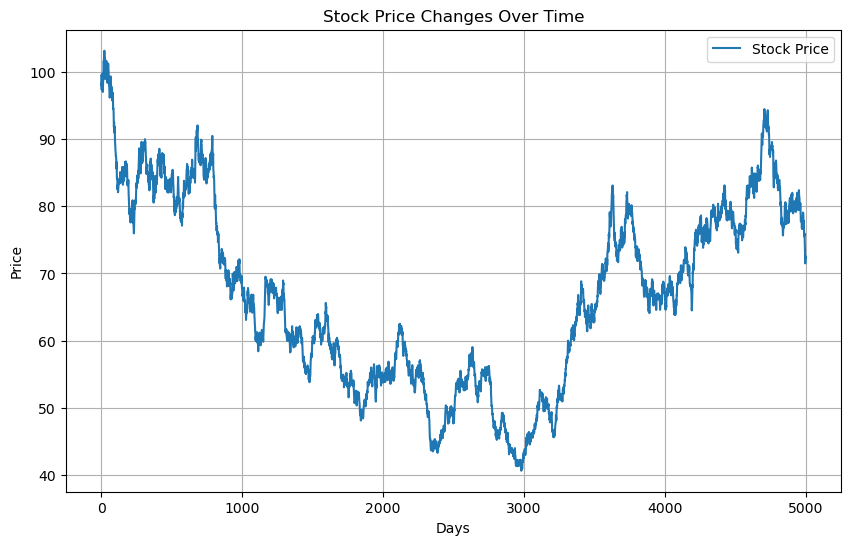

Skewness: 0.15897184741923734
Kurtosis: 0.11282709822071268


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, kurtosis, skew

def generate_skewed_kurtotic_returns(n_days, skewness, kurtosis_excess, mean_return, std_dev):
    """
    Generate random stock returns with specified skewness and kurtosis.

    Parameters:
    n_days (int): Number of days.
    skewness (float): Desired skewness.
    kurtosis_excess (float): Desired excess kurtosis (kurtosis - 3).
    mean_return (float): Mean of the returns.
    std_dev (float): Standard deviation of the returns.

    Returns:
    np.ndarray: Array of random returns.
    """
    # Generate random numbers from a skew-normal distribution
    a = skewness  # Skewness parameter
    returns = skewnorm.rvs(a, loc=mean_return, scale=std_dev, size=n_days)
    actual_skewness = skew(returns)
    print("Actual skewness:", actual_skewness)

    return returns
np.random.seed(42)  # For reproducibility
# Parameters
n_days = 5000  # Number of days
initial_price = 100  # Starting stock price
skewness = 1# Specify the skewness
kurtosis_excess = 00  # Specify the kurtosis (excess)
mean_return = -0.0056  # Mean daily return
std_dev = 0.01  # Standard deviation of daily returns

# Generate random returns with specified skewness and kurtosis
returns = generate_skewed_kurtotic_returns(n_days, skewness, kurtosis_excess, mean_return, std_dev)

# Calculate price changes
prices = initial_price * np.exp(np.cumsum(returns))

# Plot the price changes
plt.figure(figsize=(10, 6))
plt.plot(prices, label="Stock Price")
plt.title("Stock Price Changes Over Time")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Verify skewness and kurtosis
print(f"Skewness: {skew(returns)}")
print(f"Kurtosis: {kurtosis(returns)}")

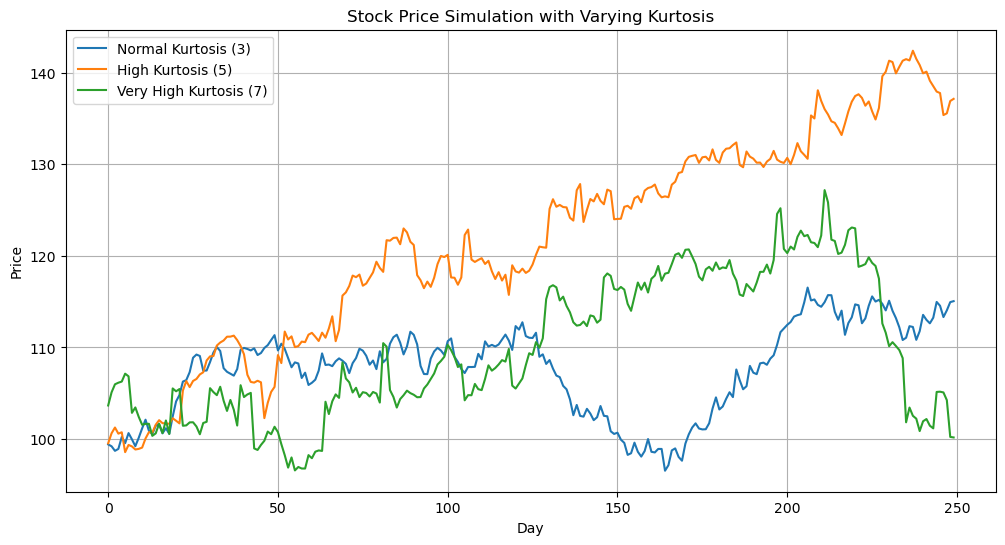

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, norm

import matplotlib.pyplot as plt

def simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level):
    """
    Simulates stock prices based on normal and kurtotic returns.

    Parameters:
    n_days (int): Number of simulation days.
    mean_return (float): Average daily return.
    std_dev (float): Standard deviation of daily returns.
    kurtosis_level (float):  kurtosis of the returns.

    Returns:
    pandas.DataFrame: DataFrame containing normal and kurtotic stock prices.
    """
    # Generate normal returns
    normal_returns = np.random.normal(mean_return, std_dev, n_days)
    # Adjust kurtosis by scaling extreme values
    if kurtosis_level > 3:
        # Calculate how many values to adjust (e.g., top/bottom 5%)
        num_adjust = int(n_days * 0.05)
        
        # Indices of largest and smallest returns
        largest_indices = normal_returns.argsort()[-num_adjust:][::-1]
        smallest_indices = normal_returns.argsort()[:num_adjust]
        
        # Scale these values to increase kurtosis
        scale_factor = np.sqrt(kurtosis_level - 3 + 1)  # Adjust scale based on desired kurtosis
        normal_returns[largest_indices] *= scale_factor
        normal_returns[smallest_indices] *= scale_factor
    
    # Calculate prices
    initial_price = 100
    normal_prices = initial_price * (1 + np.cumsum(normal_returns))
    
    # Create DataFrame
    df = pd.DataFrame({
        'Normal_Prices': normal_prices
    })
    
    return df

# Parameters
n_days = 250  # One year of trading days
mean_return = 0.001  # Average daily return
std_dev = 0.01  # Standard deviation of daily returns

# Simulate stock prices with different kurtosis levels
kurtosis_3 = simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level=3)
kurtosis_5 = simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level=5)
kurtosis_7 = simulate_stock_price(n_days, mean_return, std_dev, kurtosis_level=7)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(kurtosis_3['Normal_Prices'], label='Normal Kurtosis (3)')
plt.plot(kurtosis_5['Normal_Prices'], label='High Kurtosis (5)')
plt.plot(kurtosis_7['Normal_Prices'], label='Very High Kurtosis (7)')
plt.title('Stock Price Simulation with Varying Kurtosis')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Generate synthetic data
np.random.seed(42)
n_samples = 1000
data = {
    'feature1': np.random.randint(0, 10, n_samples),
    'feature2': np.random.randint(0, 10, n_samples),
    'feature3': np.random.randint(0, 10, n_samples),
    'target': np.random.choice(['A', 'B', 'C'], n_samples)
}
df = pd.DataFrame(data)

# Encode the target variable
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])
print("Encoded target variable:", df['target'].unique())
# Split data into training and testing sets
X = df[['feature1', 'feature2', 'feature3']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature selection using chi-square
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_train, y_train)

# Get chi-square scores and p-values
chi2_scores = chi2_selector.scores_
p_values = chi2_selector.pvalues_

# Print feature importances
print("Chi-square scores:", chi2_scores)
print("P-values:", p_values)

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Encoded target variable: [0 1 2]
Chi-square scores: [1.381487   0.68214978 4.60062242]
P-values: [0.50120328 0.71100566 0.10022765]
Accuracy: 0.3233333333333333


In [18]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create the contingency table
observed = pd.DataFrame({
    'Lung Cancer': [80000, 40000],
    'No Lung Cancer': [120000, 61000]
}, index=['Smoker', 'Non-Smoker'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(observed)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(pd.DataFrame(expected, columns=observed.columns, index=observed.index))

# Interpret the results
alpha = 0.05
print("\nInterpretation:")
if p < alpha:
    print("Reject the null hypothesis: There is a significant association between smoking status and lung cancer.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between smoking status and lung cancer.")

Chi-Square Statistic: 4.374210787441464
P-value: 0.03648672313595398
Degrees of Freedom: 1
Expected Frequencies Table:
             Lung Cancer  No Lung Cancer
Smoker      79734.219269   120265.780731
Non-Smoker  40265.780731    60734.219269

Interpretation:
Reject the null hypothesis: There is a significant association between smoking status and lung cancer.


In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Generate synthetic data
np.random.seed(42)
n_samples = 10000
data = {
    'feature1': np.random.randn(n_samples),
    'feature2': np.random.randn(n_samples),
}
df = pd.DataFrame(data)
df['target'] = 1 + 0.02 * df['feature1'] + 0.3 * df['feature2'] + np.random.randn(n_samples) * 0.5  # Linear relationship with noise    
# Prepare the data
X = df[['feature1', 'feature2']]  # Features
y = df['target']  # Target variable

# Add a constant to the features (for the intercept term)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the linear regression model
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     1436.
Date:                Sun, 01 Jun 2025   Prob (F-statistic):               0.00
Time:                        10:08:48   Log-Likelihood:                -4962.3
No. Observations:                7000   AIC:                             9931.
Df Residuals:                    6997   BIC:                             9951.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9999      0.006    170.133      0.0

In [157]:
# Open, High, Low, Close, Volume is required
import pandas_ta as ta
# ctrl and click pandas_ta, momentum->squeeze_pro, comment nan
import pandas as pd
import numpy as np
np.random.seed(42)  # For reproducibility
from numpy.linalg import cholesky

n = 20
dates = pd.date_range("2015-01-01", periods=n, freq="B")

stocks = ["GOOG", "AAPL"]



# Create a MultiIndex from product of dates and stock names
index = pd.MultiIndex.from_product([dates, stocks], names=["date", "stock"])


# Generate some sample data
data = {
    "Open": np.random.uniform(90, 150, len(index)),
    "High": np.random.uniform(150, 200, len(index)),
    "Low": np.random.uniform(50, 90, len(index)),
    "Close": np.random.uniform(10, 16, len(index)),
    "Volume": np.random.uniform(-0.25, 0.25, len(index)),
}
# data['return'] = data['price'] + np.random.uniform(-0.01, 0.01)

# Create the DataFrame
finance_df = pd.DataFrame(data, index=index)
finance_df['return'] = finance_df.groupby('stock')['Open'].transform(lambda x: (x - x.shift(1)) / x.shift(1))
# Sort the data by date and stock
# finance_df.sort_index(inplace=True)
# stocks = sorted(stocks)

print(stocks)
finance_df.head(20)


['GOOG', 'AAPL']


Open        High        Low      Close    Volume  \
date       stock                                                           
2015-01-01 GOOG   112.472407  156.101912  84.524137  14.844641 -0.066108   
           AAPL   147.042858  174.758846  74.931925  15.376548  0.066153   
2015-01-02 GOOG   133.919637  151.719426  63.235921  11.908021  0.066765   
           AAPL   125.919509  195.466020  52.542334  10.660312  0.017887   
2015-01-05 GOOG    99.361118  162.938999  62.439293  11.367611 -0.204855   
           AAPL    99.359671  183.126114  63.007333  12.562647  0.167651   
2015-01-06 GOOG    93.485017  165.585554  79.184247  14.908089 -0.089610   
           AAPL   141.970569  176.003401  75.502299  15.164383 -0.156741   
2015-01-07 GOOG   126.066901  177.335514  85.488510  10.041713 -0.229612   
           AAPL   132.484355  159.242723  68.888597  13.064484  0.045446   
2015-01-08 GOOG    91.235070  198.479231  54.783770  12.504466  0.088782   
           AAPL   148.194591  188.756641  78.529791  11.332647 -0.241706   
2015-01-09 GOOG   139.946558  196.974947  80.431402  10.719192  0.006047   
           AAPL   102.740347  194.741368  72.451088  12.025691 -0.136752   
2015-01-12 GOOG   100.909498  179.894999  80.838687  15.657458  0.072586   
           AAPL   101.004271  196.093712  69.751824  11.939218 -0.162817   
2015-01-13 GOOG   108.254535  154.424625  70.909313  13.112744  0.095469   
           AAPL   121.485386  159.799143  67.101641  14.218114 -0.056632   
2015-01-14 GOOG   115.916701  152.261364  51.016765  12.181778  0.218365   
           AAPL   107.473748  166.266517  54.315657  15.830692 -0.181240   

                    return  
date       stock            
2015-01-01 GOOG        NaN  
           AAPL        NaN  
2015-01-02 GOOG   0.190689  
           AAPL  -0.143654  
2015-01-05 GOOG  -0.258054  
           AAPL  -0.210927  
2015-01-06 GOOG  -0.059139  
           AAPL   0.428855  
2015-01-07 GOOG   0.348525  
           AAPL  -0.066818  
2015-01-08 GOOG  -0.276296  
           AAPL   0.118582  
2015-01-09 GOOG   0.533912  
           AAPL  -0.306720  
2015-01-12 GOOG  -0.278943  
           AAPL  -0.016898  
2015-01-13 GOOG   0.072788  
           AAPL   0.202775  
2015-01-14 GOOG   0.070779  
           AAPL  -0.115336

In [33]:
help(ta.cdl_doji)

Help on function cdl_doji in module pandas_ta.candles.cdl_doji:

cdl_doji(
    open_,
    high,
    low,
    close,
    length=None,
    factor=None,
    scalar=None,
    asint=True,
    offset=None,
    **kwargs
)
    Candle Type: Doji

    A candle body is Doji, when it's shorter than 10% of the
    average of the 10 previous candles' high-low range.

    Sources:
        TA-Lib: 96.56% Correlation

    Calculation:
        Default values:
            length=10, percent=10 (0.1), scalar=100
        ABS = Absolute Value
        SMA = Simple Moving Average

        BODY = ABS(close - open)
        HL_RANGE = ABS(high - low)

        DOJI = scalar IF BODY < 0.01 * percent * SMA(HL_RANGE, length) ELSE 0

    Args:
        open_ (pd.Series): Series of 'open's
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        length (int): The period. Default: 10
        factor (float): Doji value. Default: 100
      

In [154]:
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": 3, 'close': 'return'},
        {"kind": "sma", "length": 2, 'close': 'return'},
        {'kind': 'macd', 'fast': 2, 'slow': 6, 'signal': 5},
        {'kind': 'rsi', 'length': 2},
        {'kind': 'bbands', 'length': 2, 'std': 1.5, 'close': 'return'},
        {'kind': 'sma', 'length': 20, 'close': 'Volume'},
        {'kind': 'sma', 'length': 50, 'close': 'Open'},
        {'kind': 'sma', 'length': 200, 'close': 'Open'},
        {'kind': 'sma', 'length': 20, 'close': 'return'}
        
    ]
)
    
def apply_strat(x):
    x.ta.strategy(CustomStrategy)
    # x.ta.strategy('performance')
    return x

newdf = finance_df.copy()
newdf.drop(newdf.iloc[2].name, inplace=True)
newdf = newdf.groupby(['stock'], group_keys=False).apply(apply_strat)
newdf.head(60)


Open        High        Low      Close    Volume  \
date       stock                                                           
2015-01-01 GOOG   112.472407  156.101912  84.524137  14.844641 -0.066108   
           AAPL   147.042858  174.758846  74.931925  15.376548  0.066153   
2015-01-02 AAPL   125.919509  195.466020  52.542334  10.660312  0.017887   
2015-01-05 GOOG    99.361118  162.938999  62.439293  11.367611 -0.204855   
           AAPL    99.359671  183.126114  63.007333  12.562647  0.167651   
2015-01-06 GOOG    93.485017  165.585554  79.184247  14.908089 -0.089610   
           AAPL   141.970569  176.003401  75.502299  15.164383 -0.156741   
2015-01-07 GOOG   126.066901  177.335514  85.488510  10.041713 -0.229612   
           AAPL   132.484355  159.242723  68.888597  13.064484  0.045446   
2015-01-08 GOOG    91.235070  198.479231  54.783770  12.504466  0.088782   
           AAPL   148.194591  188.756641  78.529791  11.332647 -0.241706   
2015-01-09 GOOG   139.946558  196.974947  80.431402  10.719192  0.006047   
           AAPL   102.740347  194.741368  72.451088  12.025691 -0.136752   
2015-01-12 GOOG   100.909498  179.894999  80.838687  15.657458  0.072586   
           AAPL   101.004271  196.093712  69.751824  11.939218 -0.162817   
2015-01-13 GOOG   108.254535  154.424625  70.909313  13.112744  0.095469   
           AAPL   121.485386  159.799143  67.101641  14.218114 -0.056632   
2015-01-14 GOOG   115.916701  152.261364  51.016765  12.181778  0.218365   
           AAPL   107.473748  166.266517  54.315657  15.830692 -0.181240   
2015-01-15 GOOG   126.711174  169.433864  51.257167  15.774684 -0.079467   
           AAPL    98.369632  163.567452  75.456416  11.510694 -0.193263   
2015-01-16 GOOG   107.528679  191.436875  62.574239  12.983491  0.212347   
           AAPL   111.981711  167.837666  70.342828  11.805270  0.188670   
2015-01-19 GOOG   117.364199  164.046725  86.302659  11.709043 -0.121029   
           AAPL   137.110558  177.134804  59.971689  10.221322  0.079992   
2015-01-20 GOOG   101.980427  157.046211  66.415317  13.657386  0.158611   
           AAPL   120.854066  190.109849  80.222046  13.016074  0.027600   
2015-01-21 GOOG   125.544874  153.727532  59.151927  10.308873  0.014825   
           AAPL    92.787025  199.344347  53.079196  11.671879 -0.129074   
2015-01-22 GOOG   126.452691  188.612238  61.590058  15.449595 -0.203449   
           AAPL   100.231447  159.935784  56.448851  11.437371  0.198608   
2015-01-23 GOOG    93.903096  150.276106  87.187906  10.869369  0.200209   
           AAPL   146.933132  190.773071  82.324815  12.936717  0.066551   
2015-01-26 GOOG   147.937922  185.342867  75.336150  15.913903 -0.080485   
           AAPL   138.503841  186.450358  84.858424  11.452332 -0.075395   
2015-01-27 GOOG   108.276826  188.563517  82.146883  14.032813  0.112978   
           AAPL    95.860327  153.702233  57.462802  14.569718  0.198555   
2015-01-28 GOOG   131.053982  167.923286  85.702360  11.425825  0.193543   
           AAPL   116.409150  155.793453  71.573690  14.369298  0.139938   

                    return     SMA_3     SMA_2  MACD_2_6_5  MACDh_2_6_5  \
date       stock                                                          
2015-01-01 GOOG        NaN       NaN       NaN         NaN          NaN   
           AAPL        NaN       NaN       NaN         NaN          NaN   
2015-01-02 AAPL  -0.143654       NaN       NaN         NaN          NaN   
2015-01-05 GOOG  -0.258054       NaN       NaN         NaN          NaN   
           AAPL  -0.210927       NaN -0.177291         NaN          NaN   
2015-01-06 GOOG  -0.059139       NaN -0.158596         NaN          NaN   
           AAPL   0.428855  0.024758  0.108964         NaN          NaN   
2015-01-07 GOOG   0.348525  0.010444  0.144693         NaN          NaN   
           AAPL  -0.066818  0.050370  0.181018         NaN          NaN   
2015-01-08 GOOG  -0.276296  0.004363  0.036114         NaN          NaN   
       

In [167]:
def apply_ta_indicators(group):
    sma = ta.sma(group["return"], length=5)
    macd_df = ta.macd(group["Close"], fast=5, slow=10, talib=False)
    drawdown = ta.drawdown(group["Close"], talib=False)
    rsi = ta.rsi(group["Close"], length=14, talib=False)
    # Concatenate the MACD DataFrame to the group
    group = pd.concat([group, drawdown, rsi, sma, macd_df], axis=1)
    return group

# Apply the function by grouping over the "stock" level
newdf = finance_df.groupby(level="stock", group_keys=False).apply(apply_ta_indicators)
newdf

Open        High        Low      Close    Volume  \
date       stock                                                           
2015-01-01 GOOG   112.472407  156.101912  84.524137  14.844641 -0.066108   
           AAPL   147.042858  174.758846  74.931925  15.376548  0.066153   
2015-01-02 GOOG   133.919637  151.719426  63.235921  11.908021  0.066765   
           AAPL   125.919509  195.466020  52.542334  10.660312  0.017887   
2015-01-05 GOOG    99.361118  162.938999  62.439293  11.367611 -0.204855   
           AAPL    99.359671  183.126114  63.007333  12.562647  0.167651   
2015-01-06 GOOG    93.485017  165.585554  79.184247  14.908089 -0.089610   
           AAPL   141.970569  176.003401  75.502299  15.164383 -0.156741   
2015-01-07 GOOG   126.066901  177.335514  85.488510  10.041713 -0.229612   
           AAPL   132.484355  159.242723  68.888597  13.064484  0.045446   
2015-01-08 GOOG    91.235070  198.479231  54.783770  12.504466  0.088782   
           AAPL   148.194591  188.756641  78.529791  11.332647 -0.241706   
2015-01-09 GOOG   139.946558  196.974947  80.431402  10.719192  0.006047   
           AAPL   102.740347  194.741368  72.451088  12.025691 -0.136752   
2015-01-12 GOOG   100.909498  179.894999  80.838687  15.657458  0.072586   
           AAPL   101.004271  196.093712  69.751824  11.939218 -0.162817   
2015-01-13 GOOG   108.254535  154.424625  70.909313  13.112744  0.095469   
           AAPL   121.485386  159.799143  67.101641  14.218114 -0.056632   
2015-01-14 GOOG   115.916701  152.261364  51.016765  12.181778  0.218365   
           AAPL   107.473748  166.266517  54.315657  15.830692 -0.181240   
2015-01-15 GOOG   126.711174  169.433864  51.257167  15.774684 -0.079467   
           AAPL    98.369632  163.567452  75.456416  11.510694 -0.193263   
2015-01-16 GOOG   107.528679  191.436875  62.574239  12.983491  0.212347   
           AAPL   111.981711  167.837666  70.342828  11.805270  0.188670   
2015-01-19 GOOG   117.364199  164.046725  86.302659  11.709043 -0.121029   
           AAPL   137.110558  177.134804  59.971689  10.221322  0.079992   
2015-01-20 GOOG   101.980427  157.046211  66.415317  13.657386  0.158611   
           AAPL   120.854066  190.109849  80.222046  13.016074  0.027600   
2015-01-21 GOOG   125.544874  153.727532  59.151927  10.308873  0.014825   
           AAPL    92.787025  199.344347  53.079196  11.671879 -0.129074   
2015-01-22 GOOG   126.452691  188.612238  61.590058  15.449595 -0.203449   
           AAPL   100.231447  159.935784  56.448851  11.437371  0.198608   
2015-01-23 GOOG    93.903096  150.276106  87.187906  10.869369  0.200209   
           AAPL   146.933132  190.773071  82.324815  12.936717  0.066551   
2015-01-26 GOOG   147.937922  185.342867  75.336150  15.913903 -0.080485   
           AAPL   138.503841  186.450358  84.858424  11.452332 -0.075395   
2015-01-27 GOOG   108.276826  188.563517  82.146883  14.032813  0.112978   
           AAPL    95.860327  153.702233  57.462802  14.569718  0.198555   
2015-01-28 GOOG   131.053982  167.923286  85.702360  11.425825  0.193543   
           AAPL   116.409150  155.793453  71.573690  14.369298  0.139938   

                    return        DD    DD_PCT    DD_LOG     RSI_14     SMA_5  \
date       stock                                                                
2015-01-01 GOOG        NaN  0.000000  0.000000  0.000000        NaN       NaN   
           AAPL        NaN  0.000000  0.000000  0.000000        NaN       NaN   
2015-01-02 GOOG   0.190689  2.936620  0.197824  0.220427        NaN       NaN   
           AAPL  -0.143654  4.716236  0.306716  0.366316        NaN       NaN   
2015-01-05 GOOG  -0.258054  3.477030  0.234228  0.266871        NaN       NaN   
           AAPL  -0.210927  2.813901  0.183000  0.202116        NaN       NaN   
2015-01-06 GOOG  -0.059139  0.000000  0.000000  0.000000        NaN       NaN   
           AAPL   0.428855  0.212164  0.013798  0.013894        NaN       NaN   
2015-01-07 GOOG   0.3

In [145]:
help(ta.drawdown)

Help on function drawdown in module pandas_ta.performance.drawdown:

drawdown(close, offset=None, **kwargs) -> pandas.core.frame.DataFrame
    Drawdown (DD)

    Drawdown is a peak-to-trough decline during a specific period for an investment,
    trading account, or fund. It is usually quoted as the percentage between the
    peak and the subsequent trough.

    Sources:
        https://www.investopedia.com/terms/d/drawdown.asp

    Calculation:
        PEAKDD = close.cummax()
        DD = PEAKDD - close
        DD% = 1 - (close / PEAKDD)
        DDlog = log(PEAKDD / close)

    Args:
        close (pd.Series): Series of 'close's.
        offset (int): How many periods to offset the result. Default: 0

    Kwargs:
        fillna (value, optional): pd.DataFrame.fillna(value)
        fill_method (value, optional): Type of fill method

    Returns:
        pd.DataFrame: drawdown, drawdown percent, drawdown log columns



<bound method AnalysisIndicators.cdl_pattern of <pandas_ta.core.AnalysisIndicators object at 0x173047100>>

Open        High        Low       Close    Volume  \
date       stock                                                            
2015-01-01 GOOG   112.472407  168.682041  79.199932  138.288674 -0.100544   
           AAPL   147.042858  166.645605  57.380480  127.557547 -0.202591   
           MSFT   133.919637  158.807696  63.865588  157.869911 -0.186820   
           AMZN   125.919509  180.363334  76.531225  113.138707 -0.159664   
           TSLA    99.361118  173.831208  69.283574  135.271385 -0.148173   
...                      ...         ...        ...         ...       ...   
2022-08-31 GOOG   141.459359  193.851931  88.091018  145.242035  0.061223   
           AAPL   143.850530  152.340698  79.912968  145.871616 -0.136903   
           MSFT   146.802475  165.184923  50.778235  116.174166  0.124498   
           AMZN   113.849280  172.166000  66.040194  126.059186  0.010505   
           TSLA   103.028424  158.613241  60.295919  129.245422  0.180853   

                    return  ABER_ZG_5_15  ABER_SG_5_15  ABER_XG_5_15  \
date       stock                                                       
2015-01-01 GOOG        NaN           NaN           NaN           NaN   
           AAPL        NaN           NaN           NaN           NaN   
           MSFT        NaN           NaN           NaN           NaN   
           AMZN        NaN           NaN           NaN           NaN   
           TSLA        NaN    124.447794           NaN           NaN   
...                    ...           ...           ...           ...   
2022-08-31 GOOG   0.324184    129.483869    240.731883     18.235854   
           AAPL   0.091411    127.845345    236.505340     19.185350   
           MSFT  -0.130100    127.030827    236.073935     17.987719   
           AMZN  -0.008523    127.534638    236.383259     18.686016   
           TSLA  -0.168744    123.324503    231.471038     15.177969   

                  ABER_ATR_5_15  ...    HA_close  HILO_13_21  HILOl_13_21  \
date       stock                 ...                                        
2015-01-01 GOOG             NaN  ...  124.660764         NaN          NaN   
           AAPL             NaN  ...  124.656623         NaN          NaN   
           MSFT             NaN  ...  128.615708         NaN          NaN   
           AMZN             NaN  ...  123.988194         NaN          NaN   
           TSLA             NaN  ...  119.436821         NaN          NaN   
...                         ...  ...         ...         ...          ...   
2022-08-31 GOOG      111.248014  ...  142.161086         NaN          NaN   
           AAPL      108.659995  ...  130.493953         NaN          NaN   
           MSFT      109.043108  ...  119.734950         NaN          NaN   
           AMZN      108.848621  ...  119.528665         NaN          NaN   
           TSLA      108.146535  ...  112.795752         NaN          NaN   

                  HILOs_13_21         HL2        HLC3      HMA_10         HWM  \
date       stock                                                                
2015-01-01 GOOG           NaN  123.940987  128.723549         NaN  138.288674   
           AAPL           NaN  112.013042  117.194544         NaN  135.917095   
           MSFT           NaN  111.336642  126.847732         NaN  140.522978   
           AMZN           NaN  128.447279  123.344422         NaN  134.707741   
           TSLA           NaN  121.557391  126.128722         NaN  134.463290   
...                       ...         ...         ...         ...         ...   
2022-08-31 GOOG           NaN  140.971475  142.394995  140.572425  141.574011   
           AAPL           NaN  116.126833  126.041761  145.872420  144.507759   
           MSFT           NaN  107.981579  110.712441  141.466744  140.475428   
           AMZN           NaN  119.103097  121.421793  134.761230  139.024523   
           TSLA           NaN  109.454580  116.051527  128.425734  138.368561   

                         HWU 

git --version
ctrl + ,

preference, exclude git

rm -rf .git

git init

git add .

git status

git commit -m "some information about version"

git checkout -b newbranch  # this is to create a new branch

git branch -d newbranch  # this is to delete a new branch

git checkout newbranch  # switch branch to newbranch

git merge another # used to merge with 'another'

git reset --hard de62783c58c58af5e71c65a38eba65fad605dabb  # to some specific version
